In [21]:
import sys
from pathlib import Path
ROOT = Path.cwd().parent          # eine Ebene über notebooks/
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.utils_stats import iqr, trimmed_mean, tukey_fences, tukey_outliers, modified_z_score, ecdf, z_score, create_na_table
from src.utils_plots import hist_kde, box_violin, plot_ecdf, hist_with_fences, plot_qq
from matplotlib.patches import Patch
from scipy import stats

# Checkliste für Ausreisser Handling

- nach missing values prüfen
- prüfen, ob Datumswerte außerhalb vom Jahr 2023 liegen
- mit Filterkritierien unmögliche Werte ausschliessen
- Tukey- und mod. Z-Test anwenden
- Heavy Tails vs. echte Datenfehler unterscheiden
- Strategie wählen und dokumentieren

## Heatmap Missing Values

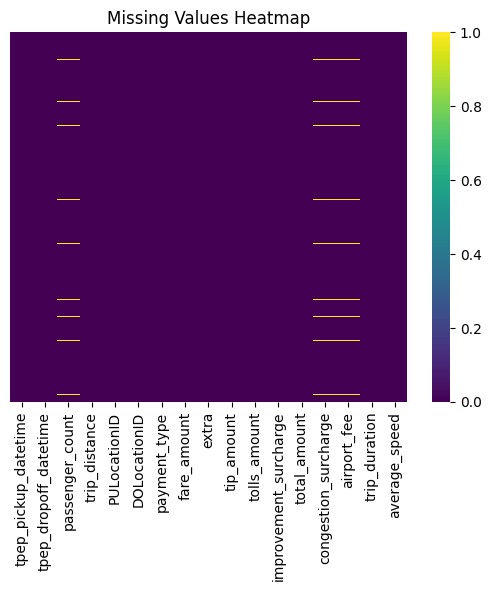

In [22]:
data = pd.read_csv("../data/Taxi_final_1M.csv")
sns.heatmap(data.isnull(), cbar=True, yticklabels=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

Wir können also sehen das bei passenger_count, congestion_surcharge und airport_fee vermutlich in der gleichen Datenreihe fehlende Werte haben. 
Um dies zu bestätigen müssen wir, wie in Abschnitt 2 bereits gemacht die genaue Anzahl bestimmen.

In [23]:
missing_count = data.isnull().sum()
missing_percent = data.isnull().mean() * 100

# Erstelle einen übersichtlichen DataFrame
missing_df = pd.DataFrame({
    'Anzahl fehlender Werte': missing_count,
    'Prozent fehlender Werte': missing_percent
})

missing_df = missing_df[missing_df['Anzahl fehlender Werte'] > 0]

print("Fehlende Werte im Datensatz:")
print(missing_df)

Fehlende Werte im Datensatz:
                      Anzahl fehlender Werte  Prozent fehlender Werte
passenger_count                        34408                  3.44081
congestion_surcharge                   34408                  3.44081
airport_fee                            34408                  3.44081
average_speed                            320                  0.03200


Unsere Vermutung hat sich bestätigt, es ist genau die gleiche Anzahl an fehlenden Werten bei den Drei. Zudem können wir feststellen das es noch eine neue Spalte gibt mit fehlenden Werten und zwar average_speed. Diese erklären sich wahrscheinlich dadurch, dass bei der erstellung von der Spalte ein paar Werte auf None gesetzt wurden.

Bevor wir diese Missing Values beheben, kopieren wir den Datensatz um das original beizubehalten.

In [24]:
# Pfade definieren
src_path = "../data/Taxi_final_1M.csv"
dest_path = "../data/Taxi_final_1M_clean.csv"

# Prüfen, ob Zieldatei bereits existiert
if os.path.exists(dest_path):
    print(f"Die Datei '{dest_path}' existiert bereits. Kopiervorgang abgebrochen.")
else:
    # CSV speichern
    data.to_csv(dest_path, index=False)

Die Datei '../data/Taxi_final_1M_clean.csv' existiert bereits. Kopiervorgang abgebrochen.


Für congestion_surcharge werden wir bei den fehlenden Werten 2.5 einfühgen, denn dies kommt mit Abstand am meisten vor, es ist ein Verkehrszuschlag der bei den Yellow Taxis 2.5$ ist und eigentlich immer verrechnet wird.

In [25]:
data["congestion_surcharge"] = data["congestion_surcharge"].fillna(2.5)

Für passanger_count werden wir einfach den Median inputieren, um möglichst im durchschnitt zu sein, der Mittelwert könnte wegen Ausreissern stark vom Median abweichen und endet oft in einer Decimalzahl was bei Passagieren nicht möglich ist.

In [26]:
data["passenger_count"] = data["passenger_count"].fillna(data["passenger_count"].median())

Für die fehlende airport_fee setzen wir Null ein, denn die meisten Fahrten gehen nicht zum FLughafen, weswegen keine fees anfallen. Zudem wäre der Median ebenfalls Null.

In [27]:
data["airport_fee"] = data["airport_fee"].fillna(0)

Für average_speed wird ebenfalls der Median genommen, da alle Taxis in der gleichen Stadt unterwegs sind und im Schnitt immer auf ähnliche Geschwindigkeiten kommen.

In [28]:
data["average_speed"] = data["average_speed"].fillna(data["average_speed"].median())

So jetzt überprüfen wir ob wir noch fehlende Werte in der Heatmap sehen können.

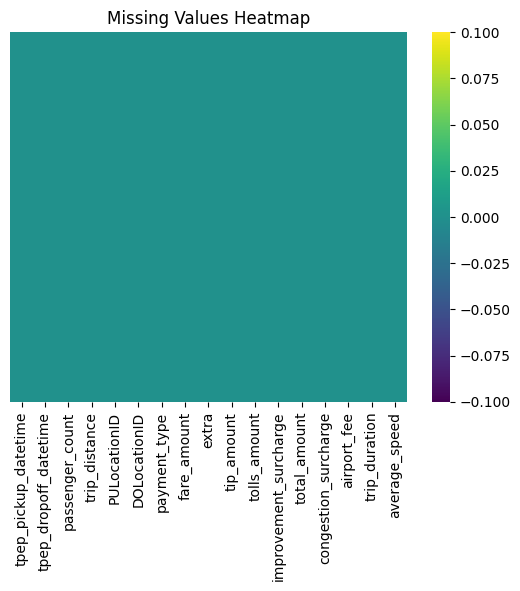

In [29]:
sns.heatmap(data.isnull(), cbar=True, yticklabels=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

## Datetime Check

Da wir mit einem Datensatz aus dem Jahr 2023 arbeiten, prüfen wir in folgendem Absatz, ob sich keine Taxifahrten aus vergangenen/zukünftigen Jahren eingeschlichen haben.
Tatsächlich haben wir besonders unter den dropoffs einige Werte aus dem Jahr 2024 gefunden. Nach weiterer Analyse der geprinteten, fehlerhaften rows, konnten wir erkennen, dass diese Taxifahrten im Jahr 2023 gestartet sind und im Jahr 2024 angekommen sind. Diese Fahrten wollen wir behalten und nicht löschen. Die Taxifahrt aus dem Jahr 2008 ist allerdings wirklich fehlerhaft und wird daher auch aus unserem CSV entfernt.

In [30]:
# 1. Datetime konvertieren
data["tpep_pickup_datetime"] = data["tpep_pickup_datetime"].astype("datetime64[ns]")
data["tpep_dropoff_datetime"] = data["tpep_dropoff_datetime"].astype("datetime64[ns]")

# 2. Überprüfen und printen, welche dropoff-dates und pickup-dates außerhalb von 2023 liegen
mask1 = (data["tpep_pickup_datetime"].dt.year == 2023)
pickup_outside_of_2023 = data[~mask1]
print(200*"=")
print("--- Pickup-Dates außerhalb des Jahres 2023 ---")
display(pickup_outside_of_2023)

mask2 = (data["tpep_dropoff_datetime"].dt.year == 2023)
dropoff_outside_of_2023 = data[~mask2]
print(200*"=")
print("--- Dropoff-Dates außerhalb des Jahres 2023 ---")
display(dropoff_outside_of_2023)
print(200*"=")

# 3. Taxifahrt aus dem Jahr 2008 anhand des Indexes löschen
data = data.drop(index=777496)
data.to_csv("../data/Taxi_final_1M_clean.csv", index=False)


--- Pickup-Dates außerhalb des Jahres 2023 ---


,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,extra,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_duration,average_speed
777496,2008-12-31 23:03:12,2009-01-01 13:50:40,1.0,2.3,142,238,2,9.3,0.0,0.0,0.0,1.0,13.3,2.5,0.0,887.5,0.2


--- Dropoff-Dates außerhalb des Jahres 2023 ---


,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,extra,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_duration,average_speed
777496,2008-12-31 23:03:12,2009-01-01 13:50:40,1.0,2.3,142,238,2,9.3,0.0,0.00,0.00,1.0,13.30,2.5,0.00,887.5,0.2
921836,2023-12-31 23:40:57,2024-01-01 00:08:06,1.0,10.0,234,255,1,32.4,1.0,9.35,0.00,1.0,46.75,2.5,0.00,27.2,22.0
931561,2023-12-31 23:57:04,2024-01-01 00:07:12,1.0,4.1,87,33,2,13.5,1.0,0.00,0.00,1.0,21.00,2.5,0.00,10.1,24.4
931960,2023-12-31 23:52:46,2024-01-01 00:26:01,2.0,30.3,132,106,1,72.3,1.0,14.96,0.00,1.0,91.51,0.0,1.75,33.2,54.7
935821,2023-12-31 20:05:36,2024-01-01 19:45:17,2.0,5.6,170,262,2,17.0,1.0,0.00,0.00,1.0,22.00,2.5,0.00,1419.7,0.2
938783,2023-12-31 23:48:52,2024-01-01 00:00:27,0.0,4.8,161,145,1,15.6,3.5,5.15,0.00,1.0,25.75,2.5,0.00,11.6,25.0
946238,2023-12-31 23:49:44,2024-01-01 00:06:56,1.0,6.0,142,68,1,20.5,1.0,5.10,0.00,1.0,30.60,2.5,0.00,17.2,20.9
948191,2023-12-31 23:53:13,2024-01-01 00:01:42,1.0,6.0,132,216,2,16.3,1.0,0.00,0.00,1.0,20.55,0.0,1.75,8.5,42.2
952452,2023-12-31 23:52:43,2024-01-01 00:33:00,1.0,5.1,68,163,1,33.8,1.0,7.76,0.00,1.0,46.56,2.5,0.00,40.3,7.6
954784,2023-12-31 23:59:59,2024-01-01 00:07:56,2.0,4.3,237,151,1,12.8,3.5,3.55,0.00,1.0,21.35,2.5,0.00,8.0,32.8


## Ausreißer-Behandlung

Jetzt wo die fehlenden Werte behandelt sind, müssen wir die **Ausreißer** identifizieren und entfernen. Dies sind unrealistische oder fehlerhafte Werte, die die Analyse verzerren würden.


In [31]:
# Statistiken vor der Bereinigung
print(f"Gesamtanzahl Fahrten: {len(data):,}")
print(f"\nVerteilung der Hauptvariablen:")
for col in ['passenger_count', 'trip_distance', 'trip_duration', 'fare_amount', 'total_amount', 'extra', 'tip_amount', 'improvement_surcharge', 'tolls_amount', 'congestion_surcharge', 'airport_fee', 'average_speed']:
    print(f"\n{col}:")
    print(f"  Min: {data[col].min():.2f}")
    print(f"  Max: {data[col].max():.2f}")
    print(f"  Median: {data[col].median():.2f}")
    print(f"  Mean: {data[col].mean():.2f}")


Gesamtanzahl Fahrten: 999,996

Verteilung der Hauptvariablen:

passenger_count:
  Min: 0.00
  Max: 8.00
  Median: 1.00
  Mean: 1.36

trip_distance:
  Min: 0.00
  Max: 148560.10
  Median: 2.90
  Mean: 6.38

trip_duration:
  Min: -52.20
  Max: 3713.80
  Median: 12.60
  Mean: 17.45

fare_amount:
  Min: -900.00
  Max: 2449.50
  Median: 13.50
  Mean: 19.46

total_amount:
  Min: -901.00
  Max: 2451.00
  Median: 21.00
  Mean: 28.39

extra:
  Min: -7.50
  Max: 14.25
  Median: 1.00
  Mean: 1.55

tip_amount:
  Min: -70.00
  Max: 700.00
  Median: 2.80
  Mean: 3.51

improvement_surcharge:
  Min: -1.00
  Max: 1.00
  Median: 1.00
  Mean: 0.98

tolls_amount:
  Min: -36.05
  Max: 85.00
  Median: 0.00
  Mean: 0.59

congestion_surcharge:
  Min: -2.50
  Max: 2.50
  Median: 2.50
  Mean: 2.27

airport_fee:
  Min: -1.75
  Max: 1.75
  Median: 0.00
  Mean: 0.14

average_speed:
  Min: -65178.30
  Max: inf
  Median: 15.40
  Mean: inf


## Filterkriterien festlegen

Wir definieren realistische Grenzwerte basierend auf:
- **Domain-Wissen** (was ist physikalisch/logisch möglich?)
- **Datenverteilung** (was sind die typischen Werte?)
- **Business-Kontext** (NYC Yellow Cabs)


In [32]:
# Ausreißer entfernen - realistische Werte behalten
data_clean = data[

    # Fahrstrecke: Minimum > 0, Maximum 400 km (extrem lange Fahrten ausschließen)
    (data['trip_distance'] > 0) & (data['trip_distance'] < 400) &

    # Fahrtdauer: Minimum > 1 Minute, Maximum 10 Stunden
    (data['trip_duration'] > 0) & (data['trip_duration'] < 600) &

    # Fahrpreis: > 0
    (data['fare_amount'] > 0) &

    # Gesamtbetrag: > 0
    (data['total_amount'] > 0) & (data['total_amount'] < 2000) &

    # Trinkgeld: >= 0
    (data['tip_amount'] >= 0) &

    # Extra: >= 0
    (data['extra'] >= 0) & 

    # Improvement Surcharge: >= 0
    (data['improvement_surcharge'] >= 0) & 

    # Mautgebühren: >= 0
    (data['tolls_amount'] >= 0) & 

    # Stauzuschlag: >= 0
    (data['congestion_surcharge'] >= 0) & 

    # Flughafen-Gebühr: >= 0
    (data['airport_fee'] >= 0) &

    # Durchschnittsgeschwindigkeit: >= 0.1
    (data['average_speed'] >= 0.1) & (data['average_speed'] <= 100)

].copy()

print(f"Ursprüngliche Zeilen: {len(data):,}")
print(f"Bereinigte Zeilen: {len(data_clean):,}")
print(f"Entfernte Zeilen: {len(data) - len(data_clean):,} ({(len(data) - len(data_clean))/len(data)*100:.2f}%)")


Ursprüngliche Zeilen: 999,996
Bereinigte Zeilen: 967,678
Entfernte Zeilen: 32,318 (3.23%)


In [33]:
# Statistiken nach der Bereinigung
for col in ['passenger_count', 'trip_distance', 'trip_duration', 'fare_amount', 'total_amount', 'extra', 'tip_amount', 'improvement_surcharge', 'tolls_amount', 'congestion_surcharge', 'airport_fee']:
    print(f"\n{col}:")
    print(f"  Min: {data_clean[col].min():.2f}")
    print(f"  Max: {data_clean[col].max():.2f}")
    print(f"  Median: {data_clean[col].median():.2f}")
    print(f"  Mean: {data_clean[col].mean():.2f}")


passenger_count:
  Min: 0.00
  Max: 8.00
  Median: 1.00
  Mean: 1.36

trip_distance:
  Min: 0.10
  Max: 184.40
  Median: 2.90
  Mean: 5.67

trip_duration:
  Min: 0.10
  Max: 598.70
  Median: 12.80
  Mean: 16.53

fare_amount:
  Min: 0.01
  Max: 705.10
  Median: 13.50
  Mean: 19.73

total_amount:
  Min: 1.01
  Max: 731.15
  Median: 21.00
  Mean: 28.86

extra:
  Min: 0.00
  Max: 14.25
  Median: 1.00
  Mean: 1.60

tip_amount:
  Min: 0.00
  Max: 700.00
  Median: 2.88
  Mean: 3.58

improvement_surcharge:
  Min: 0.00
  Max: 1.00
  Median: 1.00
  Mean: 1.00

tolls_amount:
  Min: 0.00
  Max: 85.00
  Median: 0.00
  Mean: 0.60

congestion_surcharge:
  Min: 0.00
  Max: 2.50
  Median: 2.50
  Mean: 2.33

airport_fee:
  Min: 0.00
  Max: 1.75
  Median: 0.00
  Mean: 0.14


## Tukey & mod. Z-Score

Mit Hilfe einer Visualisierung werden Ausreisser in jeder Gruppe sichtbar gemacht. Aus analyse der vorherigen Methoden kommen nur bestimmte Spalten für eine genauere Ausreisserbehandlung in Frage, da manche uninteressant sind.
folgende Spalten werden genauer untersucht:

- trip_distance
- trip_duration
- fare_amount
- total_amount

Anzahl gemeinsamer Ausreißer (beide Methoden): 129154
Anzahl nur Tukey-Ausreißer: 0
Anzahl nur Modified-Z-Score-Ausreißer: 5629


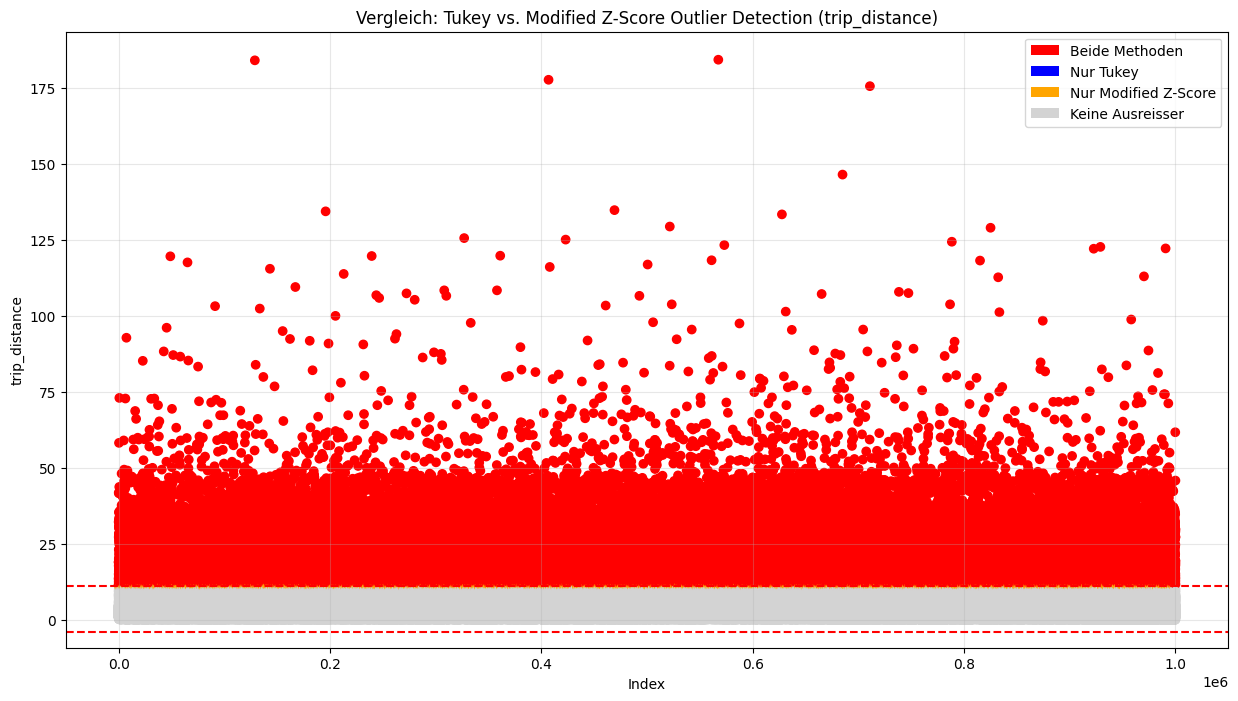

Anzahl gemeinsamer Ausreißer (beide Methoden): 46959
Anzahl nur Tukey-Ausreißer: 10399
Anzahl nur Modified-Z-Score-Ausreißer: 0


/home/benjamin/HSG/Statistik/Project/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


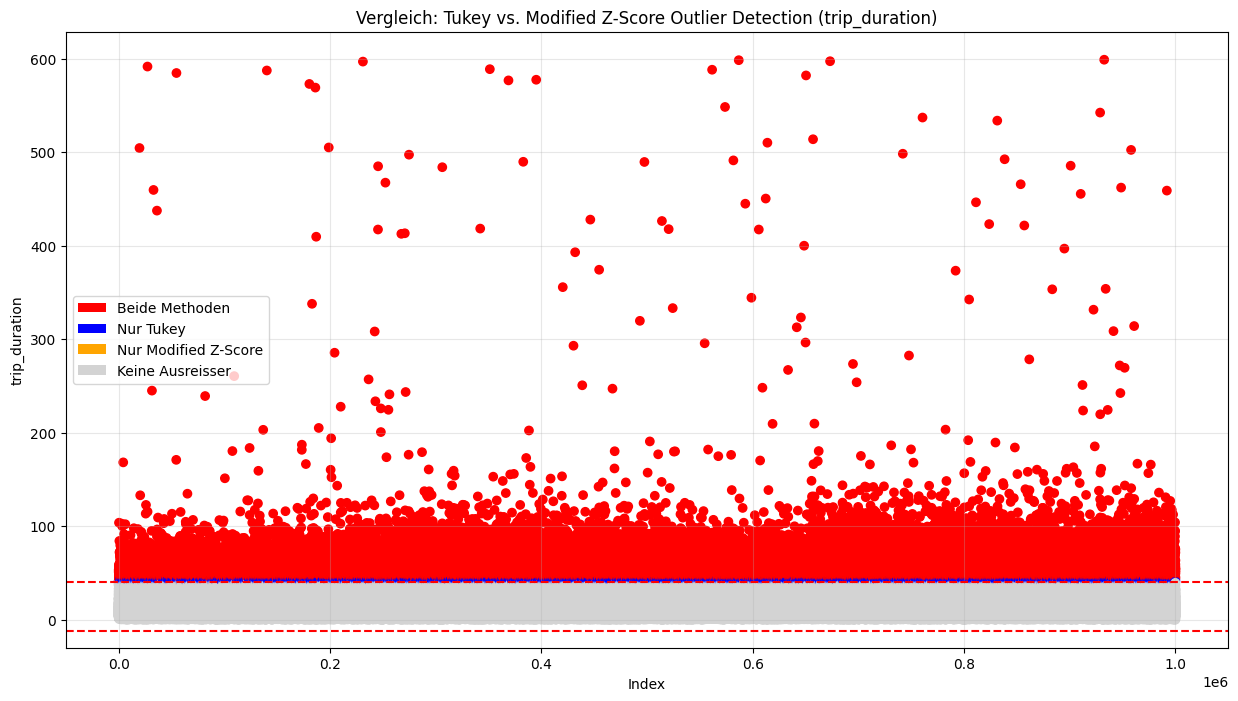

Anzahl gemeinsamer Ausreißer (beide Methoden): 99025
Anzahl nur Tukey-Ausreißer: 0
Anzahl nur Modified-Z-Score-Ausreißer: 8475


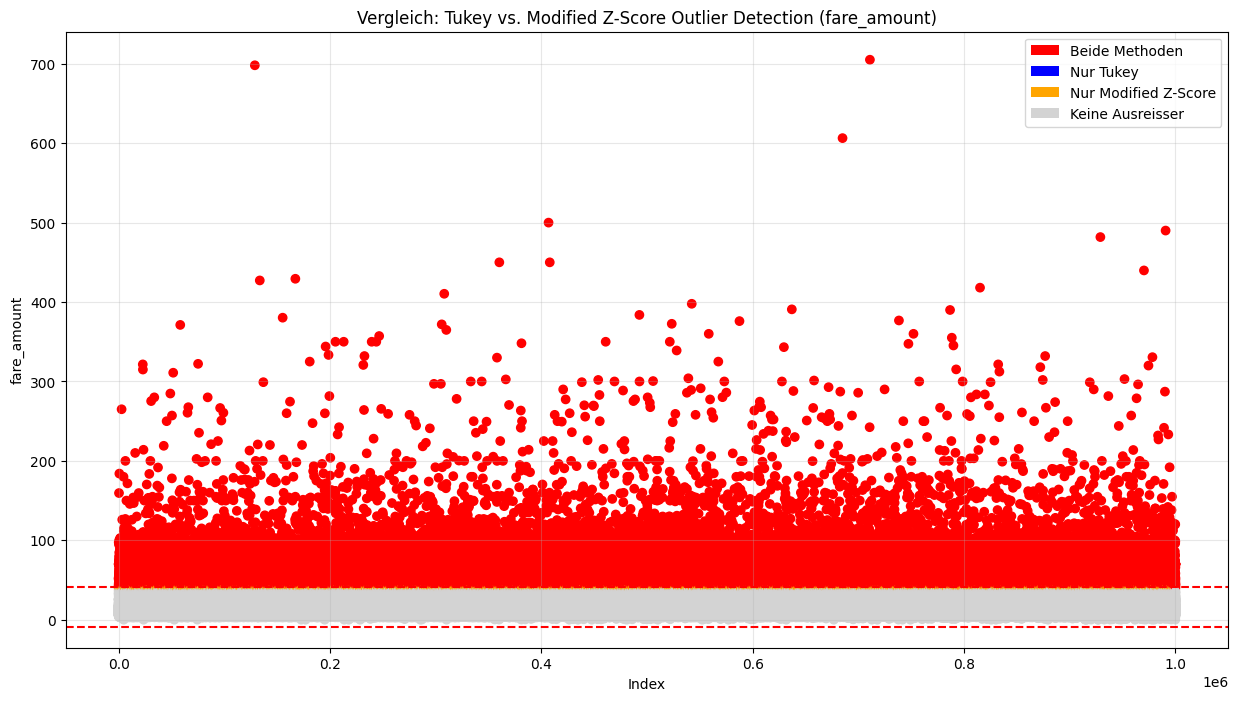

Anzahl gemeinsamer Ausreißer (beide Methoden): 110555
Anzahl nur Tukey-Ausreißer: 676
Anzahl nur Modified-Z-Score-Ausreißer: 0


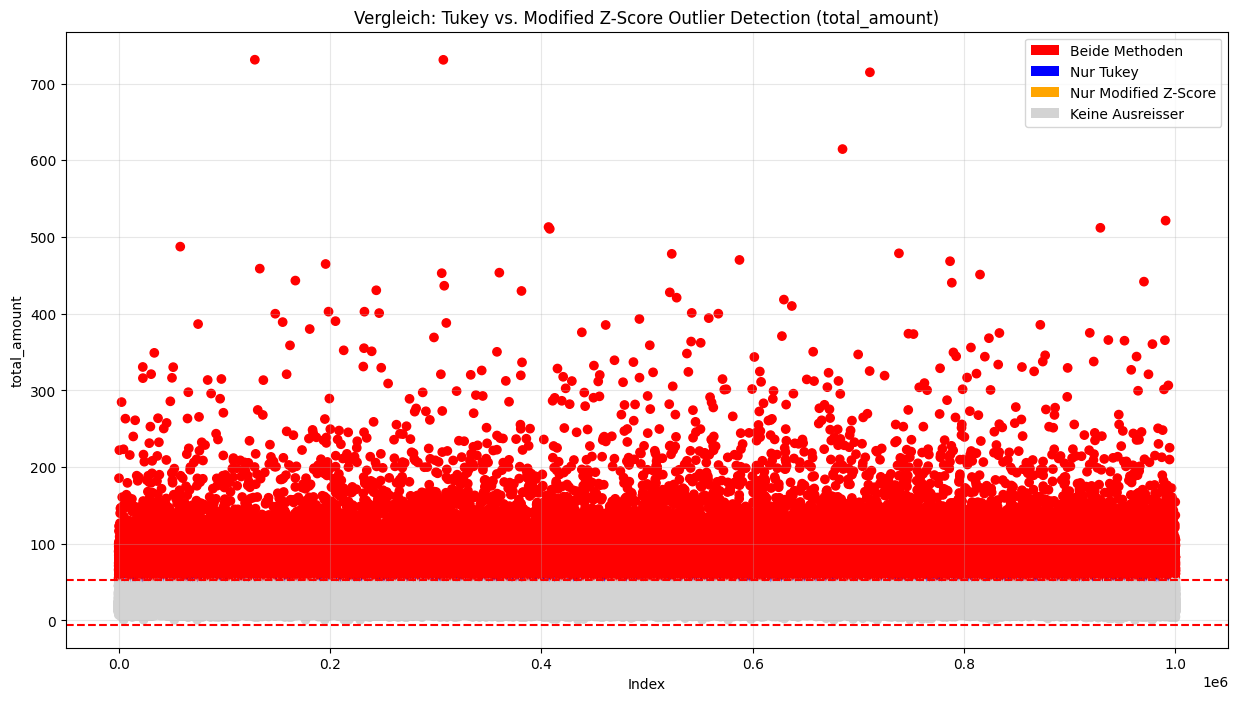

In [34]:
cols = ['trip_distance', 'trip_duration', 'fare_amount', 'total_amount']

for col in cols:
    s = data_clean[col]

    # Masken berechnen
    modz_mask = modified_z_score(s)
    tukey_mask = tukey_outliers(s)

    # Gemeinsame / nur-eine-Methode Ausreißer
    common_outliers = s.index[modz_mask & tukey_mask]
    only_tukey = s.index[tukey_mask & ~modz_mask]
    only_modified_z = s.index[modz_mask & ~tukey_mask]

    lower_bound, upper_bound = tukey_fences(s)

    print("Anzahl gemeinsamer Ausreißer (beide Methoden):", len(common_outliers))
    print("Anzahl nur Tukey-Ausreißer:", len(only_tukey))
    print("Anzahl nur Modified-Z-Score-Ausreißer:", len(only_modified_z))

    # Farben definieren
    colors = []
    for idx in data_clean.index:
        if idx in common_outliers:
            colors.append('red')
        elif idx in only_tukey:
            colors.append('blue')
        elif idx in only_modified_z:
            colors.append('orange')
        else:
            colors.append('lightgray')

    # Plot
    plt.figure(figsize=(15, 8))
    plt.scatter(data_clean.index, s, c=colors)

    plt.axhline(y=lower_bound, color='red', linestyle='--', label=f'Untere Tukey-Grenze: {lower_bound:.2f}')
    plt.axhline(y=upper_bound, color='red', linestyle='--', label=f'Obere Tukey-Grenze: {upper_bound:.2f}')

    plt.xlabel('Index')
    plt.ylabel(col)
    plt.title(f'Vergleich: Tukey vs. Modified Z-Score Outlier Detection ({col})')
    plt.grid(True, alpha=0.3)

    # Legende
    legend_elements = [
        Patch(facecolor='red', label='Beide Methoden'),
        Patch(facecolor='blue', label='Nur Tukey'),
        Patch(facecolor='orange', label='Nur Modified Z-Score'),
        Patch(facecolor='lightgray', label='Keine Ausreisser')
    ]
    plt.legend(handles=legend_elements)
    plt.show()

## QQ-Plots

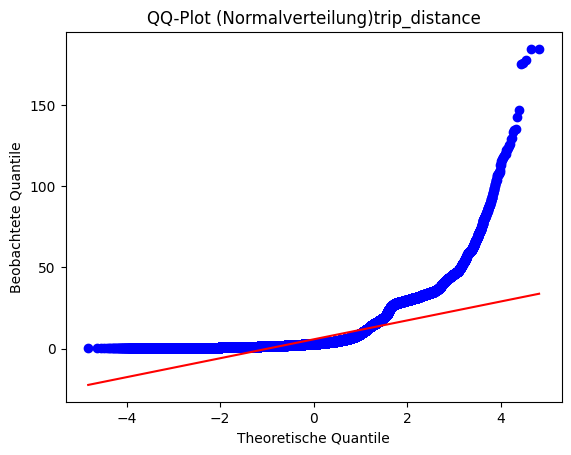

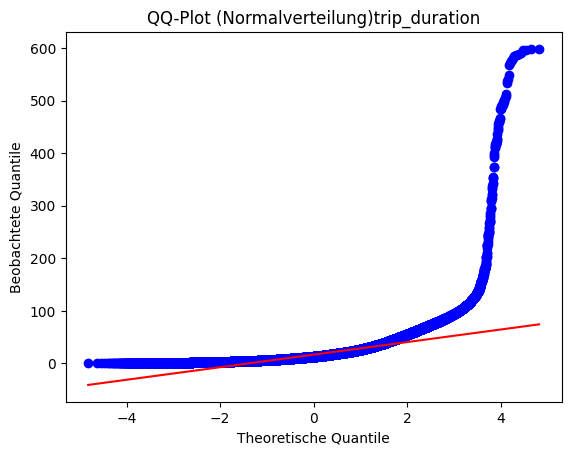

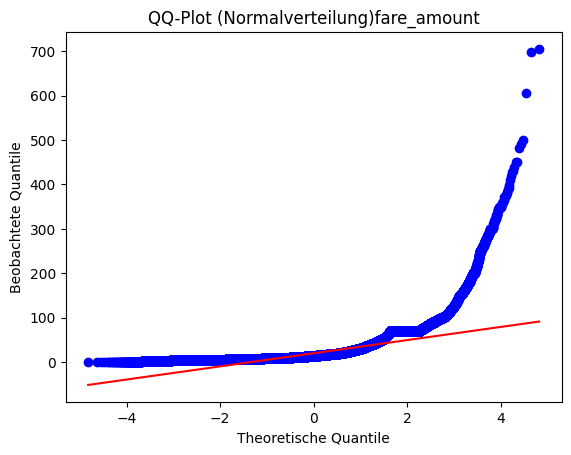

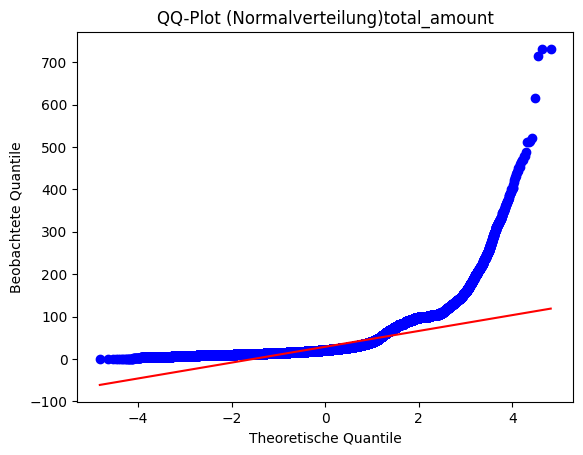

In [16]:
for col in cols:
    stats.probplot(data_clean[col].dropna(), dist="norm", plot=plt)

    plt.title("QQ-Plot (Normalverteilung)" + col)
    plt.xlabel("Theoretische Quantile")
    plt.ylabel("Beobachtete Quantile")
    plt.show()

## Entscheidung zu Ausreisserbehandlung

Wie wir schnell sehen können sind unsere Daten linksschief, was darauf hindeuted das es sehr viele kurze Fahrten gibt, was für ein Taxiunternehmen in New York gerechtfertigt ist. Aber uns ist aufgefallen, das es relativ viele Fahrten gibt, die zum Teil sehr lang sind und fast nichts kosten, deshalb werden wir eine Funktion einfühgen, die solche werte entfernt. 

--> wenn total amount kleiner ist als 3 (minimum charge in einem Taxi) + trip_distance dann werden wir den Wert entfernen

In [35]:
data_final = data_clean[(data_clean['total_amount'] > 3 + data_clean['trip_distance'])].copy()

print(f"Ursprüngliche Zeilen: {len(data_clean):,}")
print(f"Bereinigte Zeilen: {len(data_final):,}")
print(f"Entfernte Zeilen: {len(data_clean) - len(data_final):,} ({(len(data_clean) - len(data_final))/len(data_clean)*100:.2f}%)")

data_final.to_csv(dest_path, index=False)

Ursprüngliche Zeilen: 967,678
Bereinigte Zeilen: 967,493
Entfernte Zeilen: 185 (0.02%)
